In [1]:
# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
import warnings
# warnings.filterwarnings(action = "ignore")

# 데이터 처리 모듈
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import time
from tqdm import tqdm
pd.options.display.float_format = "{:.5f}".format
# pd.reset_option("display.float_format")

# 멀티프로세싱
import multiprocessing as mp
from multiprocessing import Pool

# 척도 변환 모듈(표준화, 정규화, 로버스트 정규화, 원핫인코딩(범주형에서 더미변수로 변환) 등)
from sklearn.preprocessing import *

# 결측값 관측 모듈
import missingno as msno

# 시각화 모듈
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# 배열, 행렬 연산 모듈
import numpy as np

# 데이터 분할 모듈(훈련용 / 검증용 / 시험용)
from sklearn.model_selection import train_test_split

# 통계적 가설검정 및 계량화 모듈
# https://youtu.be/FtWEZw3kUho
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.interpolate import UnivariateSpline

# 타입 어노테이션 모듈
from typing import *

# 시간 관련 모듈
from tqdm import tqdm
from time import strptime, sleep

# 웹크롤링 / 스크래핑 관련 모듈
import requests
import io
import zipfile
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

# 결측값 대체 및 특징 추출
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, SparsePCA

# 연관규칙 분석 실행 모듈
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# 한글폰트 설정
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
import matplotlib.patches as mpatches

Mounted at /content/drive


**6개의 투자심리 측정변수**
* NYSE의 거래회전율
* 배당금 프리미엄
* 폐쇄형 펀드의 할인
율
* IPO의 첫 거래일 평균 수익률
* 채권 대비 주식발행 비중
* 투자심리선은 해당 종목이 과매수 또는 과매도 상태인지를 파악함으로써 투자자 심리가 낙관적인지 비관적인지를 판단하는데 사용하며, 일반적으로 75% 이상이면 해당 주식이 과매수 상태, 25% 이하이면 과매도 상태로 해석

**6개 변수를 이용하여 월별 투자 심리지수를 도출**
* ```개인투자자의 매수매도 불균형(BSI, buying and selling imbalance of individual investors)```

* ```주식형 펀드 유입액(FUND, stock fund flow ratio)```

  예금이나 채권형 펀드에서 위험한 주식형 펀드로 자금이 이동하는 현상

* ```소비자 기대지수(CEI, customer expectation index)```
  
  통계청에서 발간하는 소비자 기대지수는 경기 순환을 예측하는 지수로 본 연구에서는 자연로그를 취하여 사용(경기선행지수 중 1)

  (i) 현재생활형편, 생활형편전망, 가계수입전망, 소비지출전망, 현재경기판단, 향후경기전망 6개의 개별지수의 합산지수 산출

  (ii) 표준화하고, 6개 구성지수 표준편차의 중간값을 가중치로 곱하여 소비자 심리지수 산출

  (iii) 100보다 높으면 주관적 기대심리 과거 평균 대비 낙관적으로 해석(기준치 상회 여부 및 지수 자체의 증감 중요)

* ```주식투자 예치금(CD, customer’s deposit for stock investment)```
  
  주식투자를 위해 예치한 금액이 얼마나 변동하였는지를 측정하여 추가적으로 고려한다. 주식투자 예치금은 주식을 매수하기 위한 일시적인 예치금으로 투자자들이 주식시장에 대해 보다 낙관적인 견해를 가지고 있을수록 증가

* ```상장주식 거래회전율(TURN, turnover ratio)```

* ```주식 자금조달 비율(SR, equity shares issued ratio)```

  주식과 채권을 합계한 총 자금 조달금액에서 주식발행을 통해 조달한 자금의 비중을 사용

* 투자심리지수 파생컬럼

0) **10세 기준 연령대, 관리사원 존재여부**

1) **전환율(CTR)**

    매수전환율 = 매수체결횟수 / 접속일수
    
    매도전환율 = 매도체결횟수 / 접속일수

* CONN_DYS < MTS_DYS + HTS_DYS
* 특정기간동안의 HTS 또는 MTS 접속일수

2) **최고자산 대비 등락률**

    {(월말일 기준 예수금 등 현금성 자산액 + 월말일 기준 국내주식 자산 평가액 + 월말일 기준 해외주식 자산 평가액) - (과거 최고자산액)} / (과거 최고자산액) * 100

    특이 시점 - 과거 최고자산액 기록 연월

3) **거래회전율 = 1월부터 3월까지 총 거래량 / 특정기간동안의 거래량**
  
    주식매수대금회전율 = 3개월간 주식 매수액 합계 / 특정기간동안의 주식 매수액 합계

    주식매도대금회전율 = 3개월간 주식 매도액 합계 / 특정기간동안의 주식 매도액 합계
    
    주식매수량회전율 = 3개월간 주식 매수종목수 합계 / 특정기간동안의 주식 매수종목수 합계
    
    주식매도량회전율 = 3개월간 주식 매도종목수 합계 / 특정기간동안의 주식 매도종목수 합계

4) **주식수익률**

    국내주식수익률 = 월말일 기준 국내주식 자산 평가액 / 월말일 기준 국내주식 자산 매입액
    해외주식수익률 = 월말일 기준 국내주식 자산 평가액 / 월말일 기준 국내주식 자산 매입액


5) **매수매도 불균형(IBSI)**

    매수매도불균형 = 특정기간동안의 주식 매수액 합계 / 특정기간동안의 주식 매도액 합계

6) **대체입출고비중[타 증권사 주식이체]  >= 50%**
    
    유가증권대체입고[진입율] = (특정기간동안의 주식 입고액 합계 + 특정기간동안의 입금액 합계) / (월말일 기준 예수금 등 현금성 자산액 + 월말일 기준 국내주식 자산 평가액)

    유가증권대체출고[이탈률] = (특정기간동안의 주식 출고액 합계 + 특정기간동안의 출금액 합계) / (월말일 기준 예수금 등 현금성 자산액 + 월말일 기준 국내주식 자산 평가액)
    
7) **분산투자지표**

    (특정기간동안의 주식매수액 1위 종목매수액 합계 + 특정기간동안의 주식매수액 2위 종목매수액 합계 + 특정기간동안의 주식매수액 3위 종목매수액 합계) /  특정기간동안의 주식 매수액 합계

    (특정기간동안의 주식매도액 1위 종목매도액 합계 + 특정기간동안의 주식매도액 2위 종목매도액 합계 + 특정기간동안의 주식매도액 3위 종목매도액 합계) /  특정기간동안의 주식 매도액 합계


8) **이전6개월 매도액 중 특정기간 이내의 매수매도발생 매도액비중** (PCA)


* 나를 위한 것만은 아닌 기록

```
CS_DATA_M2_3_BUY1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_BUY1.csv", index_col = False).fillna(0)
CS_DATA_M2_3_BUY2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_BUY2.csv", index_col = False).fillna(0)
CS_DATA_M2_3_BUY3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_BUY3.csv", index_col = False).fillna(0)
CS_DATA_M2_3_SELL1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_SELL1.csv", index_col = False).fillna(0)
CS_DATA_M2_3_SELL2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_SELL2.csv", index_col = False).fillna(0)
CS_DATA_M2_3_SELL3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_SELL3.csv", index_col = False).fillna(0)
```

```
CS_DATA_M3_1_BUY1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_BUY1.csv", index_col = False).fillna(0)
CS_DATA_M3_1_BUY2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_BUY2.csv", index_col = False).fillna(0)
CS_DATA_M3_1_BUY3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_BUY3.csv", index_col = False).fillna(0)
CS_DATA_M3_1_SELL1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_SELL1.csv", index_col = False).fillna(0)
CS_DATA_M3_1_SELL2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_SELL2.csv", index_col = False).fillna(0)
CS_DATA_M3_1_SELL3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_SELL3.csv", index_col = False).fillna(0)
```

```
CS_DATA_M4_2_BUY1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_BUY1.csv", index_col = False).fillna(0)
CS_DATA_M4_2_BUY2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_BUY2.csv", index_col = False).fillna(0)
CS_DATA_M4_2_BUY3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_BUY3.csv", index_col = False).fillna(0)
CS_DATA_M4_2_SELL1 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_SELL1.csv", index_col = False).fillna(0)
CS_DATA_M4_2_SELL2 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_SELL2.csv", index_col = False).fillna(0)
CS_DATA_M4_2_SELL3 = pd.read_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_SELL3.csv", index_col = False).fillna(0)
```

```
CONSUMER_ID = pd.merge(
    CS_DATA_M2_3["고객번호"], CS_DATA_M3_1["고객번호"], how = "inner")
CONSUMER_ID = pd.merge(
    CS_DATA_M4_2["고객번호"], CONSUMER_ID, how = "inner")

for dataframe in [CS_DATA_M2_3, CS_DATA_M3_1, CS_DATA_M4_2]:
    # 150446 | 194670 | 168290
  print(len(dataframe))
len(CONSUMER_ID)
  # 91024
```

* 1,2,3위 평가액 또는 매입액 합계 > 전체 평가액 또는 매입액보다 큰 경우는 익명처리 과정에서 다른 값으로 대체되거나 금액이 특정 자리 이하로 절삭됨에  따라 발생한 케이스로, 해당 내용 분석에 참고하시기 바랍니다.

### **1.투자심리지수 파생변수 생성**

In [2]:
class MutateColumn():

  def __init__(self, M2_3_file_path: str, M3_1_file_path: str, M4_2_file_path: str, CS_DATA_MONTH_DATA = None):

    self.CS_DATA_M2_3_BUY1 = pd.read_csv(M2_3_file_path, index_col = False).fillna(0)
    self.CS_DATA_M3_1_BUY1 = pd.read_csv(M3_1_file_path, index_col = False).fillna(0)
    self.CS_DATA_M4_2_BUY1 = pd.read_csv(M4_2_file_path, index_col = False).fillna(0)
    self.CS_DATA_MONTH_DATA = CS_DATA_MONTH_DATA


  def readDataset(self):
    return self.CS_DATA_M2_3_BUY1, self.CS_DATA_M3_1_BUY1, self.CS_DATA_M4_2_BUY1


  def periodDatetime(self, basedate: str, dataframe: pd.DataFrame):
    # for basedate, dataframe in zip(["202301", "202302", "202303"], [self.CS_DATA_M2_3_BUY1, self.CS_DATA_M3_1_BUY1, self.CS_DATA_M4_2_BUY1]):
    dataframe["과거 최고자산액 기록 연월"] = dataframe["과거 최고자산액 기록 연월"].apply(
        lambda data: datetime.datetime.strptime(str(data), "%Y%m"))
    dataframe["과거 최고자산액 기록 연월"] = ( datetime.datetime.strptime(basedate, "%Y%m") - dataframe["과거 최고자산액 기록 연월"] )
      # [timedelta] 두 날짜 또는 시간의 차이가 어느정도인지 나타낼 때 사용하는 모듈
    dataframe["과거 최고자산액 기록 연월"] = dataframe["과거 최고자산액 기록 연월"].dt.days
    return dataframe


  def linearCombinationPCA(self, dataset: pd.DataFrame, k: int):
  # 1. 표준화
    # mean_matrix = dataset.mean()
    # std_matrix = dataset.std()
    # substract_mean_matrix = (dataset - mean_matrix)

  # 2. 공분산 행렬(Calculate the Covariance Matrix of the mean-centered data.)
    covariance_matrix = np.cov(dataset.T)
    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

  # 3. 고윳값과 고유벡터를 내림차순 정렬(모든 고유벡터는 서로 직교함)
    sorted_index = np.arange(0, len(eigen_values), 1)
    sorted_index = ([x for _, x
                     in sorted(zip(eigen_values, sorted_index))])[::-1]

    sorted_eigen_values = eigen_values[sorted_index]
    sorted_eigen_vectors = eigen_vectors[:, sorted_index]
    # print("내림차순 정렬한 고유값",  "\n", sorted_eigen_values, "\n", "내림차순 정렬한 고유벡터",  "\n", sorted_eigen_vectors)

  # 4. 원하는 결합정도에 따라 상위 k의 고유벡터를 선택하는데 모든 고유값의 누적합계로  설명된 분산 기여율 계산
    sum_eigen_values = np.sum(sorted_eigen_values)
    explained_variance = sorted_eigen_values / sum_eigen_values
    cummulative_variance = np.cumsum(explained_variance)
    # print("누적 분산 기여율", "\n", cummulative_variance, "\n")

  # 5. 변환된 데이터로 고유벡터의 전치행렬의 내적을 취하여 원본 데이터를 결합(데이터를 중앙에 배치하기 위해 평균을 뺌)
    n_components = k
      # k = 1
    eigen_vectors_subset = sorted_eigen_vectors[:, 0:n_components]

  # 6. 고유벡터를 사용하여 데이터의 좌표방향변환(회전) -> 정사영 / 투영 / 내적
    pca_matrix = np.dot(dataset, eigen_vectors_subset)
    # print("좌표변환한 행렬", "\n", pca_matrix, "\n")

    reduction_matrix = pd.Series(np.array(pca_matrix, ndmin = 1).tolist())
    for parenthesis in ["[", "]"]:
      reduction_matrix = reduction_matrix.apply(lambda data: str(data).replace(parenthesis, ""))
    reduction_matrix = reduction_matrix.astype("float")
    # reduction_matrix.index = dataset.index
    return abs(reduction_matrix)


  def mutateInvestorSentimentIndex(self, dataframe):
  # CS_DATA_MONTH_LIST: List = []
    CS_DATA_MONTH_DATA = pd.DataFrame()

  # 고객번호 | 연령대 | 관리사원 존재여부
    CS_DATA_MONTH_DATA["고객번호"] = dataframe["고객번호"]
    CS_DATA_MONTH_DATA["10세기준_연령대"] = dataframe["10세 기준 연령대"]
    CS_DATA_MONTH_DATA["관리사원_존재여부"] = dataframe["관리사원 존재여부"].apply(lambda data: 1 if data == "Y" else 0)

  # 전환율
    CS_DATA_MONTH_DATA["매수전환율"] = dataframe["특정기간동안의 주식 매수체결횟수"] / dataframe["특정기간동안의 HTS 또는 MTS 접속일수"]
    CS_DATA_MONTH_DATA["매도전환율"] = dataframe["특정기간동안의 주식 매도체결횟수"] / dataframe["특정기간동안의 HTS 또는 MTS 접속일수"]

  # 최고자산 대비 등락률 및 변동기간
    CS_DATA_MONTH_DATA["최고자산_대비_등락률"] = (
        ((dataframe["월말일 기준 예수금 등 현금성 자산액"] + dataframe["월말일 기준 국내주식 자산 평가액"] + dataframe["월말일 기준 해외주식 자산 평가액"]) - dataframe["과거 최고자산액"]) / dataframe["과거 최고자산액"]) * 100
    CS_DATA_MONTH_DATA["최고자산_대비_변동기간"] = dataframe["과거 최고자산액 기록 연월"]

  # 거래회전율 = 1월부터 3월까지 총 거래량 / 특정기간동안의 거래량
    CS_DATA_MONTH_DATA["주식매수대금회전율"] = (dataframe["3개월간 주식 매수액 합계"] / dataframe["특정기간동안의 주식 매수액 합계"])
    CS_DATA_MONTH_DATA["주식매도대금회전율"] = (dataframe["3개월간 주식 매도액 합계"] / dataframe["특정기간동안의 주식 매도액 합계"])
    CS_DATA_MONTH_DATA["주식매수회전율"] = (dataframe["3개월간 주식 매수종목수 합계"] / dataframe["특정기간동안의 주식 매수종목수"])
    CS_DATA_MONTH_DATA["주식매도회전율"] = (dataframe["3개월간 주식 매도종목수 합계"] / dataframe["특정기간동안의 주식 매도종목수"])

  # 수익률
    CS_DATA_MONTH_DATA["국내주식수익률"] = (dataframe["월말일 기준 국내주식 자산 평가액"] / dataframe["월말일 기준 국내주식 자산 매입액"])
    CS_DATA_MONTH_DATA["해외주식수익률"] = (dataframe["월말일 기준 해외주식 자산 평가액"] / dataframe["월말일 기준 해외주식 자산 매입액"])

  # 매수매도 불균형
    CS_DATA_MONTH_DATA["매수매도불균형"] = (dataframe["특정기간동안의 주식 매수액 합계"] / dataframe["특정기간동안의 주식 매도액 합계"])

  # 대체입출고비중
    CS_DATA_MONTH_DATA["유가증권대체입고비중[진입률]"] = ( (dataframe["특정기간동안의 주식 입고액 합계"] + dataframe["특정기간동안의 입금액 합계"]) / (dataframe["월말일 기준 예수금 등 현금성 자산액"] + dataframe["월말일 기준 국내주식 자산 평가액"]) )
    CS_DATA_MONTH_DATA["유가증권대체출고비중[이탈률]"] = ( (dataframe["특정기간동안의 주식 출고액 합계"] + dataframe["특정기간동안의 출금액 합계"]) / (dataframe["월말일 기준 예수금 등 현금성 자산액"] + dataframe["월말일 기준 국내주식 자산 평가액"]) )

  # 분산투자지표
    CS_DATA_MONTH_DATA["분산투자지표_매수기준"] = ( (dataframe["특정기간동안의 주식매수액 1위 종목매수액 합계"] + dataframe["특정기간동안의 주식매수액 2위 종목매수액 합계"] + dataframe["특정기간동안의 주식매수액 3위 종목매수액 합계"]) / (dataframe["특정기간동안의 주식 매수액 합계"]) )
    CS_DATA_MONTH_DATA["분산투자지표_매도기준"] = ( (dataframe["특정기간동안의 주식매도액 1위 종목매수액 합계"] + dataframe["특정기간동안의 주식매도액 2위 종목매수액 합계"] + dataframe["특정기간동안의 주식매도액 3위 종목매수액 합계"]) / (dataframe["특정기간동안의 주식 매도액 합계"]) )

    CS_DATA_MONTH_DATA["이전6개월_매도액중_특정기간이내의_매수후_매도액비중"] = self.linearCombinationPCA(
        dataset = dataframe[["이전6개월 매도액 중 당일매수매도발생 매도액비중",
                             "이전6개월 매도액 중 매수 후 5일 이내 매도액비중",
                             "이전6개월 매도액 중 매수 후 30일 이내 매도액비중",
                             "이전6개월 매도액 중 매수 후 180일 이내 매도액비중",
                             "이전6개월 매도액 중 매수 후 1년 이내 매도액비중",
                             "이전6개월 매도액 중 매수 후 2년 이후 이내 매도액비중"]], k = 1)
  # CS_DATA_MONTH_LIST.append(CS_DATA_MONTH_DATA)
    return CS_DATA_MONTH_DATA


  def loadDataset(self):
    self.CS_DATA_M2_3 = self.periodDatetime(basedate = "202301", dataframe = self.CS_DATA_M2_3_BUY1)
    self.CS_DATA_M2_3 = self.mutateInvestorSentimentIndex(self.CS_DATA_M2_3_BUY1).fillna(0)
    self.CS_DATA_M2_3 = self.CS_DATA_M2_3.replace([np.inf, -np.inf], 0)

    self.CS_DATA_M3_1 = self.periodDatetime(basedate = "202302", dataframe = self.CS_DATA_M3_1_BUY1)
    self.CS_DATA_M3_1 = self.mutateInvestorSentimentIndex(self.CS_DATA_M3_1_BUY1).fillna(0)
    self.CS_DATA_M3_1 = self.CS_DATA_M3_1.replace([np.inf, -np.inf], 0)

    self.CS_DATA_M4_2 = self.periodDatetime(basedate = "202303", dataframe = self.CS_DATA_M4_2_BUY1)
    self.CS_DATA_M4_2 = self.mutateInvestorSentimentIndex(self.CS_DATA_M4_2_BUY1).fillna(0)
    self.CS_DATA_M4_2 = self.CS_DATA_M4_2.replace([np.inf, -np.inf], 0)

    return self.CS_DATA_M2_3, self.CS_DATA_M3_1, self.CS_DATA_M4_2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
ClusterInstance = MutateColumn(
  M2_3_file_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M2_3_BUY1.csv",
  M3_1_file_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M3_1_BUY1.csv",
  M4_2_file_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/CS_DATA_M4_2_BUY1.csv"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
BEFORE_DATA_M2_3, BEFORE_DATA_M3_1, BEFORE_DATA_M4_2 = ClusterInstance.readDataset()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
CS_DATA_M2_3, CS_DATA_M3_1, CS_DATA_M4_2 = ClusterInstance.loadDataset()
  # CS_DATA_M2_3 = ClusterInstance.mutateInvestorSentimentIndex(dataframe = RAW_DATA_M2_3)
  # CS_DATA_M3_1 = ClusterInstance.mutateInvestorSentimentIndex(dataframe = RAW_DATA_M3_1)
  # CS_DATA_M4_2 = ClusterInstance.mutateInvestorSentimentIndex(dataframe = RAW_DATA_M4_2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
pd.set_option("display.max_column", None)
display(CS_DATA_M2_3.loc[(CS_DATA_M2_3["분산투자지표_매수기준"] > 1)])
display(CS_DATA_M3_1.loc[(CS_DATA_M3_1["분산투자지표_매수기준"] > 1)])
display(CS_DATA_M4_2.loc[(CS_DATA_M4_2["분산투자지표_매수기준"] > 1)])
# BEFORE_DATA_M2_3[["특정기간동안의 주식매수액 1위 종목매수액 합계", "특정기간동안의 주식매수액 2위 종목매수액 합계", "특정기간동안의 주식매수액 3위 종목매수액 합계", "특정기간동안의 주식 매수액 합계"]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,고객번호,10세기준_연령대,관리사원_존재여부,매수전환율,매도전환율,최고자산_대비_등락률,최고자산_대비_변동기간,주식매수대금회전율,주식매도대금회전율,주식매수회전율,주식매도회전율,국내주식수익률,해외주식수익률,매수매도불균형,유가증권대체입고비중[진입률],유가증권대체출고비중[이탈률],분산투자지표_매수기준,분산투자지표_매도기준,이전6개월_매도액중_특정기간이내의_매수후_매도액비중
1,3,40,1,0.00000,0.00000,-76.66667,365,32.62000,17.14667,390000007.50000,7.50000,0.00000,0.00000,0.66667,0.00000,0.00000,1.05000,0.99333,0.38359
28,123,40,0,1.20000,0.20000,-15.33333,122,9.78000,15.30556,566676.66667,21.00000,0.81000,0.76190,1.66667,0.00000,0.00000,1.06333,1.00000,0.10827
31,132,50,0,1.33333,0.16667,1.42857,122,10.21667,39.79310,8.00000,15.00000,1.00000,0.00000,4.13793,0.00000,0.00000,1.05000,1.00000,0.14803
39,198,40,0,0.37500,0.37500,-94.54545,730,5.70000,6.05000,6.33333,10.00000,0.97778,0.00000,1.08333,0.25000,0.18333,1.00769,1.07500,0.47152
57,303,50,0,0.57143,0.14286,68.68421,396,16.85714,21.36364,17000009.00000,16.00000,0.91667,1.03093,1.90909,0.00000,0.00000,1.03810,1.00000,0.19514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150424,803178,60,0,0.75000,0.75000,-33.95652,275,74.84091,65.42222,18500010.00000,10.00000,1.00000,0.00000,0.97778,0.00000,0.00000,1.00682,0.98444,0.21270
150425,803182,50,0,0.27273,0.18182,-13.31600,275,18.86000,16.05333,2750010.00000,10.50000,1.04839,0.00000,1.00000,0.00000,0.00000,1.01333,0.99067,0.04309
150429,803207,30,0,0.50000,0.16667,-80.88235,2771,1.89381,1.07909,4.33333,5.00000,1.00000,0.76056,1.90909,0.90909,0.00000,1.00952,1.00000,0.29614
150430,803209,40,0,0.40000,0.40000,-25.46078,275,8.95652,8.95652,8.00000,8.00000,0.97436,0.00000,1.00000,0.00000,0.00000,1.02609,1.02609,0.10428


,고객번호,10세기준_연령대,관리사원_존재여부,매수전환율,매도전환율,최고자산_대비_등락률,최고자산_대비_변동기간,주식매수대금회전율,주식매도대금회전율,주식매수회전율,주식매도회전율,국내주식수익률,해외주식수익률,매수매도불균형,유가증권대체입고비중[진입률],유가증권대체출고비중[이탈률],분산투자지표_매수기준,분산투자지표_매도기준,이전6개월_매도액중_특정기간이내의_매수후_매도액비중
3,5,50,0,1.12500,1.12500,-58.57143,671,94.41818,22.42667,220000006.00000,4.75000,0.57333,0.00000,0.73333,0.04598,0.04828,1.08545,0.93733,0.28482
5,7,30,0,0.77778,0.11111,-35.52632,184,7.05736,275.61538,26500027.00000,51.00000,0.00000,0.00000,40.76923,0.01020,0.00000,1.00377,1.00000,0.30613
16,57,50,0,0.40000,0.40000,-6.34921,123,5.90000,4.80952,9000010.50000,10.50000,0.97619,0.00000,0.95238,1.01695,0.00000,1.01000,0.96190,0.40326
22,75,40,0,0.42857,0.28571,6.31579,245,1.30000,1.00000,1.33333,1.00000,0.85870,0.00000,1.48649,0.49505,0.00000,1.00909,1.00000,0.44957
40,148,60,0,1.37500,1.87500,-76.00326,2588,16.42857,10.56622,8000010.33333,15.00000,0.91667,0.00000,0.70000,0.00000,0.09512,1.00190,0.98889,0.41682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194621,803088,50,0,0.28571,0.42857,-32.30769,761,44.00000,9.18182,9000019.00000,13.00000,1.00000,0.00000,0.29545,0.00000,0.00000,1.01538,0.98864,0.22968
194624,803096,60,1,3.66667,8.00000,-46.36364,761,10.10526,8.66667,73333342.66667,9.33333,0.76623,0.00000,0.90476,0.04068,0.01525,1.01579,1.02857,0.28706
194643,803178,60,0,2.30000,2.60000,-38.87826,306,5.06615,4.52923,18500010.00000,10.00000,1.00000,0.00000,1.00000,0.00711,0.00000,1.00154,0.99538,0.10887
194664,803277,20,0,0.00000,0.00000,-23.33333,92,1.63617,1.00000,1000003.50000,2.00000,0.00000,0.92857,1.04444,0.37500,0.00000,1.00426,1.00000,0.12312


,고객번호,10세기준_연령대,관리사원_존재여부,매수전환율,매도전환율,최고자산_대비_등락률,최고자산_대비_변동기간,주식매수대금회전율,주식매도대금회전율,주식매수회전율,주식매도회전율,국내주식수익률,해외주식수익률,매수매도불균형,유가증권대체입고비중[진입률],유가증권대체출고비중[이탈률],분산투자지표_매수기준,분산투자지표_매도기준,이전6개월_매도액중_특정기간이내의_매수후_매도액비중
1,5,50,0,7.66667,3.11111,-35.23810,699,4.51565,1.77053,220000006.00000,6.33333,0.55333,0.00000,1.21053,0.25735,0.02206,1.00870,1.03158,0.31068
14,57,50,0,0.70000,0.90000,-19.20635,151,8.42857,6.73333,6000007.00000,7.00000,1.00000,0.00000,0.93333,0.00000,0.00000,1.05000,0.99333,0.42012
16,64,50,0,0.77778,0.44444,0.00000,638,20.48462,33.01515,23000008.00000,21.00000,1.00000,0.00000,1.96970,0.37500,0.17188,1.05385,1.00000,0.32705
17,68,60,0,0.50000,0.33333,-75.25000,3195,6.91875,6.63636,900006.33333,6.00000,0.77143,0.00000,1.45455,0.00000,0.00000,1.02500,1.01818,0.03265
27,109,30,0,0.85714,0.14286,-43.61111,669,10.60000,1.20769,2350006.00000,3.00000,0.81481,0.82258,0.53846,0.00000,0.00000,1.02381,1.00000,0.66497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168269,803211,20,0,0.37500,0.25000,-17.27273,334,5.87273,5.51852,8666672.00000,9.50000,0.87500,0.00000,1.35802,0.20330,0.28571,1.01818,0.98765,0.08316
168271,803222,60,0,0.50000,0.25000,-99.68889,699,2.35000,1.18824,3333336.00000,4.00000,0.76344,0.00000,1.17647,23.21429,5.83333,1.06000,1.00000,0.25343
168279,803246,60,1,0.85714,0.71429,-33.75000,699,21.74545,11.28000,733344.00000,6.80000,0.91667,0.00000,0.44000,0.00000,0.00000,1.04455,0.84800,0.66497
168281,803257,40,0,1.44444,0.77778,208.16327,212,3.59259,5.21765,4333340.33333,11.33333,1.00000,1.00000,1.58824,0.17730,0.17730,1.02519,0.98118,0.17728


In [ ]:
print( Counter(CS_DATA_M2_3["10세기준_연령대"]), "\n", Counter(CS_DATA_M3_1["10세기준_연령대"]), "\n", Counter(CS_DATA_M4_2["10세기준_연령대"]) )

Counter({50: 54890, 40: 38828, 60: 35436, 30: 16276, 20: 5016}) 
 Counter({50: 70551, 40: 50941, 60: 44067, 30: 22143, 20: 6968}) 
 Counter({50: 62799, 40: 42858, 60: 39977, 30: 17412, 20: 5244})


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
M2_3 = {50: 54890, 40: 38828, 60: 35436, 30: 16276, 20: 5016}
M3_1 = {50: 70551, 40: 50941, 60: 44067, 30: 22143, 20: 6968}
M4_2 = {50: 62799, 40: 42858, 60: 39977, 30: 17412, 20: 5244}
TOTAL = {50: 261059, 60: 137959, 40: 231250, 30: 126121, 20: 46919}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print([INDEX / sum(M2_3.values()) for INDEX in list(M2_3.values())])
print([INDEX / sum(M3_1.values()) for INDEX in list(M3_1.values())])
print([INDEX / sum(M4_2.values()) for INDEX in list(M4_2.values())])
print([INDEX / sum(TOTAL.values()) for INDEX in list(TOTAL.values())])

[0.36484851707589433, 0.2580859577522832, 0.23553966207144092, 0.10818499661007937, 0.03334086649030217]
[0.3624133148404993, 0.2616787383777675, 0.22636769918323316, 0.11374633995993219, 0.03579390763856783]
[0.37315942717927386, 0.25466753817814486, 0.2375482797551845, 0.10346425812585418, 0.031160496761542575]
[0.3249799578741902, 0.1717386108441594, 0.2878721486652691, 0.15700204653756716, 0.0584072360788141]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(
    np.round([0.36484851707589433, 0.2580859577522832, 0.23553966207144092, 0.10818499661007937, 0.03334086649030217], 5),
    np.round([0.3624133148404993, 0.2616787383777675, 0.22636769918323316, 0.11374633995993219, 0.03579390763856783], 5),
    np.round([0.37315942717927386, 0.25466753817814486, 0.2375482797551845, 0.10346425812585418, 0.031160496761542575], 5),
    np.round([0.3249799578741902, 0.1717386108441594, 0.2878721486652691, 0.15700204653756716, 0.0584072360788141], 5))

[0.36485 0.25809 0.23554 0.10818 0.03334] [0.36241 0.26168 0.22637 0.11375 0.03579] [0.37316 0.25467 0.23755 0.10346 0.03116] [0.32498 0.17174 0.28787 0.157   0.05841]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({50: 261059, 60: 137959, 40: 231250, 30: 126121, 20: 46919})

In [ ]:
# Counter(cs_merge_data["AGE_TCD"])

___

### **2.밀도 기반의 이상치 탐지 클러스터링**

In [7]:
class ClusteringAnalysis():

  def __init__(self, dataframe: pd.DataFrame):
    self.dataframe = dataframe


  def featureEngineering(self):
    robust_scaler = RobustScaler()

    consumer_matrix = self.dataframe[["고객번호", "10세기준_연령대", "관리사원_존재여부"]]
    self.dataframe = pd.DataFrame(
        robust_scaler.fit_transform(self.dataframe.drop(["고객번호", "10세기준_연령대", "관리사원_존재여부"], axis = 1)),
        columns = self.dataframe.drop(["고객번호", "10세기준_연령대", "관리사원_존재여부"], axis = 1).columns)
    self.dataframe[["고객번호", "10세기준_연령대", "관리사원_존재여부"]] = consumer_matrix
    return self.dataframe


  def correlationMatrixPlot(self):
    font_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/NanumSquareRoundR.ttf"
    font_name = fm.FontProperties(fname = font_path, size = 10).get_name()
    plt.rc("font", family = font_name)
    # plt.rcParams["font.family"] = font_name

    correlation = self.dataframe.drop("고객번호", axis = 1).corr()
    mask = np.zeros_like(correlation, dtype = np.bool)
    mask[np.triu_indices_from( mask )] = True

    sns.heatmap(
        data = correlation,
        cmap = "GnBu_r",
        annot = True,
        fmt = "0.01f",
        mask = mask,
          # [표시하지 않을 위쪽 삼각형 마스크 부분 지정]
        linewidths = 0.5,
          # [경계면 실선으로 구분]
        vmin = -1,
        vmax = 1
          # [colorbar의 범위 -1 ~ 1로 지정]
    )
    plt.show()


  def densityBasedClustering(self, epsilon: float, minPts: int):
    # 이웃의 거리 (epsilon) 설정
    # 최소 이웃 데이터 수 (minPts) 설정
    from sklearn.cluster import DBSCAN

    dbscan = DBSCAN(eps = epsilon, min_samples = minPts)
    clusters = dbscan.fit_predict(self.dataframe)
    self.dataframe["DensityBasedClusters"] = clusters
    return self.dataframe


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
DS_M2 = ClusteringAnalysis(dataframe = CS_DATA_M2_3) # CS_DATA_M3_1, CS_DATA_M4_2
CS_DATA_M2_3_Scaled = DS_M2.featureEngineering()
# DS.correlationMatrixPlot()
# CS_DATA_M2_3_Scaled = DS.densityBasedClustering(epsilon = 0.005, minPts = 5)
# print(Counter(CS_DATA_M2_3_Scaled["DensityBasedClusters"]))
# CS_DATA_M2_3_Scaled

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
DS_M3 = ClusteringAnalysis(dataframe = CS_DATA_M3_1)
CS_DATA_M3_1_Scaled = DS_M3.featureEngineering()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
DS_M4 = ClusteringAnalysis(dataframe = CS_DATA_M4_2)
CS_DATA_M4_2_Scaled = DS_M4.featureEngineering()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, make_scorer

def silhouette_scorer(data, labels):
    return silhouette_score(data, labels)

def custom_silhouette_score(estimator, data):
    labels = estimator.fit_predict(data)
    return silhouette_scorer(data, labels)

def gridSearchDensityBasedClustering(epsilon: float, minPts: int, CS_DATA_M2_3_Scaled):
    dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
    param_grid = {'eps': [0.005, 0.001, 0.0001], 'min_samples': [5, 10, 15]}   
    grid_search = GridSearchCV(estimator=dbscan, param_grid=param_grid, cv=5, scoring=make_scorer(custom_silhouette_score))
    grid_search.fit(CS_DATA_M2_3_Scaled)
    

    print("Best Parameters:", grid_search.best_params_)
    print("Best Silhouette Score:", grid_search.best_score_)

하고 적당한 값 넣어서
gridSearchDensityBasedClustering(epsilon_value, minPts_value, CS_DATA_M2_3_Scaled)로 호출하기

### **3. K-중심경향치 클러스터링**

* https://zephyrus1111.tistory.com/193

In [ ]:
display(CS_DATA_M2_3_Scaled)
display(CS_DATA_M3_1_Scaled)
display(CS_DATA_M4_2_Scaled)

In [12]:
from sklearn.cluster import *

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


```
for CS_DATA in [CS_DATA_M2_3_Scaled, CS_DATA_M3_1_Scaled, CS_DATA_M4_2_Scaled]:
  distortions: List = []

  for index in range(1, 15, 1):
    kmeans = KMeans(
        n_clusters = index,
        init = "k-means++",
        n_init = 10,
        max_iter = 300,
        random_state = 2023 )
    kmeans.fit(CS_DATA.drop(["고객번호"], axis = 1))
    distortions.append(kmeans.inertia_)

  plt.plot(
      range(1, 15, 1),
      distortions,
      marker = "o"
  )

  plt.xlabel("Number of K-means Clusters")
  plt.ylabel("Distortion")
  plt.show()
```

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


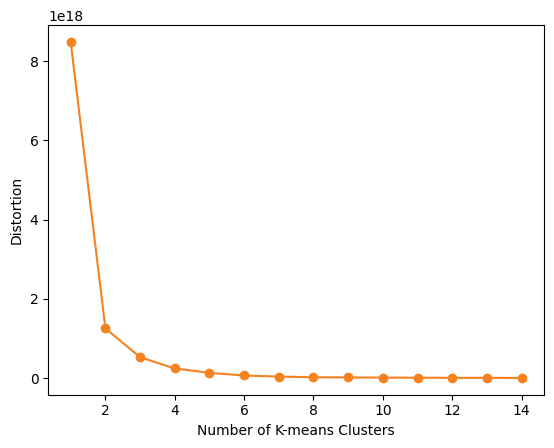

In [13]:
distortions: List = []
for index in range(1, 15, 1):
  kmeans = KMeans(
      n_clusters = index,
      init = "k-means++",
      n_init = 10,
      max_iter = 300,
      random_state = 2023 )
  kmeans.fit(CS_DATA_M2_3_Scaled.drop(["고객번호"], axis = 1))
  distortions.append(kmeans.inertia_)

plt.plot(
    range(1, 15, 1),
    distortions,
    marker = "o",
    color = "#F58220"
)

plt.xlabel("Number of K-means Clusters")
plt.ylabel("Distortion")
plt.show()
  # orange : #F58220 | #F0B26B | #CB6015 | #AD624E | #84888B
  # blue : #043B72 | #00A9CE | #0086B8 | #7E9FC3 | #8DC8E8
  # #48535B | #C2AC97 | #84888B | #A0A6A8
  # #CDCECB | #E5E4E1 | #ECEFF4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


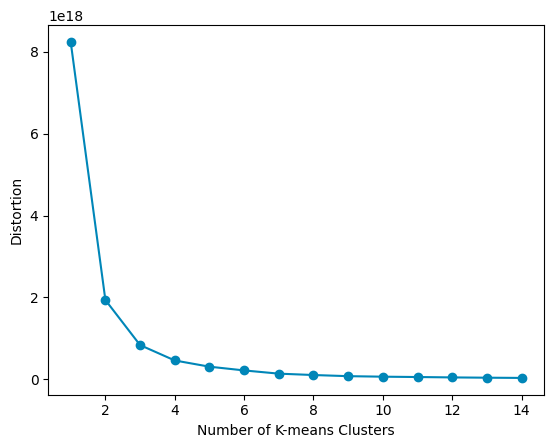

In [14]:
distortions: List = []
for index in range(1, 15, 1):
  kmeans = KMeans(
      n_clusters = index,
      init = "k-means++",
      n_init = 10,
      max_iter = 300,
      random_state = 2023 )
  kmeans.fit(CS_DATA_M3_1_Scaled.drop(["고객번호"], axis = 1))
  distortions.append(kmeans.inertia_)

plt.plot(
    range(1, 15, 1),
    distortions,
    marker = "o",
    color = "#0086B8"
)

plt.xlabel("Number of K-means Clusters")
plt.ylabel("Distortion")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


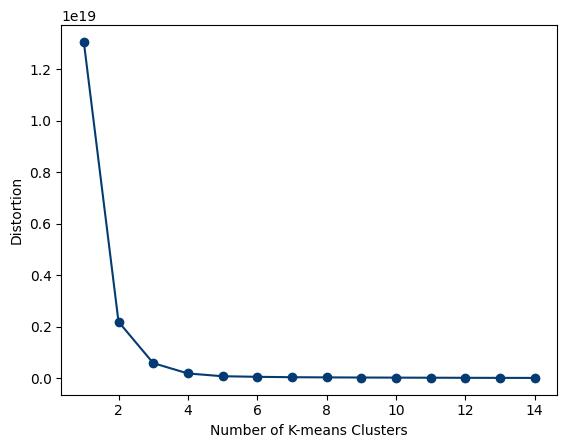

In [15]:
distortions: List = []
for index in range(1, 15, 1):
  kmeans = KMeans(
      n_clusters = index,
      init = "k-means++",
      n_init = 10,
      max_iter = 300,
      random_state = 2023 )
  kmeans.fit(CS_DATA_M4_2_Scaled.drop(["고객번호"], axis = 1))
  distortions.append(kmeans.inertia_)

plt.plot(
    range(1, 15, 1),
    distortions,
    marker = "o",
    color = "#043B72"
)

plt.xlabel("Number of K-means Clusters")
plt.ylabel("Distortion")
plt.show()

In [47]:
kmeans1 = KMeans(
    n_clusters = 3,
    init = "k-means++",
    n_init = 10,
    max_iter = 300,
    random_state = 2023 )
kmeans1_object = kmeans1.fit(CS_DATA_M2_3_Scaled.loc[CS_DATA_M2_3_Scaled["관리사원_존재여부"] == 0, :].drop(["고객번호", "관리사원_존재여부", "유가증권대체입고비중[진입률]",	"유가증권대체출고비중[이탈률]"], axis = 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
Counter(kmeans1_object.labels_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({0: 128053, 2: 29, 1: 5})

In [49]:
pd.options.display.float_format = "{:.5f}".format
# pd.reset_option("display.float_format")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
pd.options.display.float_format = "{:.5f}".format
kmeans1_object.cluster_centers_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 8.65092791e-01,  8.76946928e-01,  1.67580239e-01,
         4.12282929e-01,  2.85270104e+00,  2.52628003e+00,
         1.37928330e+00,  2.94668305e-01, -2.11724609e-01,
         1.72380839e-01,  1.80785064e+00, -5.10282216e-01,
        -5.73878864e-01,  3.03094053e-03,  4.59907226e+01],
       [ 1.18253968e-01, -3.16446429e-01,  1.28728223e-01,
         6.50387597e-01,  3.41264274e+03,  1.09638777e+04,
         5.83431059e+01,  6.01118012e+00,  6.49320798e-02,
         1.83333333e-01,  2.37865179e+03, -9.21169739e-03,
        -3.52380952e-01,  4.62487026e-01,  4.60000000e+01],
       [ 4.25717976e+00, -1.20028479e-01,  2.61320455e+00,
         1.10932906e-02,  4.39431534e-02,  9.08897650e+02,
         5.18606449e+00,  1.09761191e+00, -1.09011797e-01,
         2.57510207e-01,  3.30984738e+03, -9.76538178e-02,
        -8.72369902e-02, -1.21431702e-01,  4.24137931e+01]])

In [39]:
kmeans2 = KMeans(
    n_clusters = 3,
    init = "k-means++",
    n_init = 10,
    max_iter = 300,
    random_state = 2023 )
kmeans2_object = kmeans2.fit(CS_DATA_M3_1_Scaled.drop(["고객번호", "관리사원_존재여부", "유가증권대체입고비중[진입률]",	"유가증권대체출고비중[이탈률]"], axis = 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
Counter(kmeans2_object.labels_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({0: 194634, 2: 22, 1: 14})

In [41]:
kmeans3 = KMeans(
      n_clusters = 3,
      init = "k-means++",
      n_init = 10,
      max_iter = 300,
      random_state = 2023 )
kmeans3_object = kmeans3.fit(CS_DATA_M4_2_Scaled.drop(["고객번호", "관리사원_존재여부", "유가증권대체입고비중[진입률]",	"유가증권대체출고비중[이탈률]"], axis = 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
Counter(kmeans3_object.labels_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({0: 168255, 1: 12, 2: 23})

___

In [108]:
CS_PCA = SparsePCA(n_components = 3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
CS_DATA_M2_3_PC = CS_PCA.fit_transform( CS_DATA_M2_3_Scaled.drop(["고객번호"], axis = 1) )
CS_DATA_M3_1_PC = CS_PCA.fit_transform( CS_DATA_M3_1_Scaled.drop(["고객번호"], axis = 1) )
CS_DATA_M4_2_PC = CS_PCA.fit_transform( CS_DATA_M4_2_Scaled.drop(["고객번호"], axis = 1) )

# CS_PCA.explained_variance_ratio_.cumsum()
# array([0.9983927, 1.       , 1.       ])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
CS_DATA_M2_3_PC = pd.DataFrame(CS_DATA_M2_3_PC, columns = ["PC1", "PC2", "PC3"])
CS_DATA_M2_3_PC["고객번호"] = CS_DATA_M2_3["고객번호"]
CS_DATA_M3_1_PC = pd.DataFrame(CS_DATA_M3_1_PC, columns = ["PC1", "PC2", "PC3"])
CS_DATA_M3_1_PC["고객번호"] = CS_DATA_M3_1["고객번호"]
CS_DATA_M4_2_PC = pd.DataFrame(CS_DATA_M4_2_PC, columns = ["PC1", "PC2", "PC3"])
CS_DATA_M4_2_PC["고객번호"] = CS_DATA_M4_2["고객번호"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
CONSUMER_ID = pd.merge(
    CS_DATA_M2_3_PC, CS_DATA_M3_1_PC, left_on = "고객번호", right_on = "고객번호", how = "inner")
CONSUMER_ID = pd.merge(
    CS_DATA_M4_2_PC, CONSUMER_ID, left_on = "고객번호", right_on = "고객번호", how = "inner")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
CONSUMER_ID

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PC1,PC2,PC3,고객번호,PC1_x,PC2_x,PC3_x,PC1_y,PC2_y,PC3_y
0,-71519.83547,-446.42793,-6.12286,3,-50438.57318,-3567.84198,-4.56321,-57962.29224,-458.39954,-4.39731
1,-71516.84967,-449.02591,-6.17020,5,-50437.89247,-3568.34289,3.59755,-57959.44575,-458.47130,4.51836
2,-71494.82853,-443.96264,-2.05162,7,-50438.57318,-3567.84197,-6.07883,-57962.11598,-458.12404,30.83237
3,-71506.94774,-446.96707,13.13731,14,-50437.00991,-3567.92779,1.70673,-57959.75004,-456.51869,2.23454
4,-71521.04652,-442.05262,-5.96182,16,-50438.57318,-3567.84197,-3.88089,-57962.29224,-458.39954,-4.82869
...,...,...,...,...,...,...,...,...,...,...
91019,-71518.25021,-452.15521,-5.37039,803248,-50438.57318,-3567.84197,-4.78304,-57954.59597,-446.37012,-5.48057
91020,-71516.07095,-460.02852,-5.38080,803265,-50433.05870,-3564.34046,-5.83908,-57962.29224,-458.39954,-5.68363
91021,-71520.81354,-442.89433,-6.00020,803273,-50437.53756,-3567.18439,-5.39519,-57961.67081,-458.79712,-4.57912
91022,-71515.64115,-444.44694,-5.32089,803287,-50415.47179,-3562.17533,-4.76944,-57916.88139,-450.16473,-4.12537


In [104]:
kmeans1 = KMeans(
    n_clusters = 3,
    init = "k-means++",
    n_init = 10,
    max_iter = 300,
    random_state = 2023 )
kmeans1_object = kmeans1.fit(CONSUMER_ID.iloc[:, 0:3])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
CONSUMER_ID["Kmeans_cluster"] = kmeans1_object.labels_
  # .cluster_centers
Centroid = kmeans1_object.cluster_centers_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
Counter(kmeans1_object.labels_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({0: 91010, 2: 12, 1: 2})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


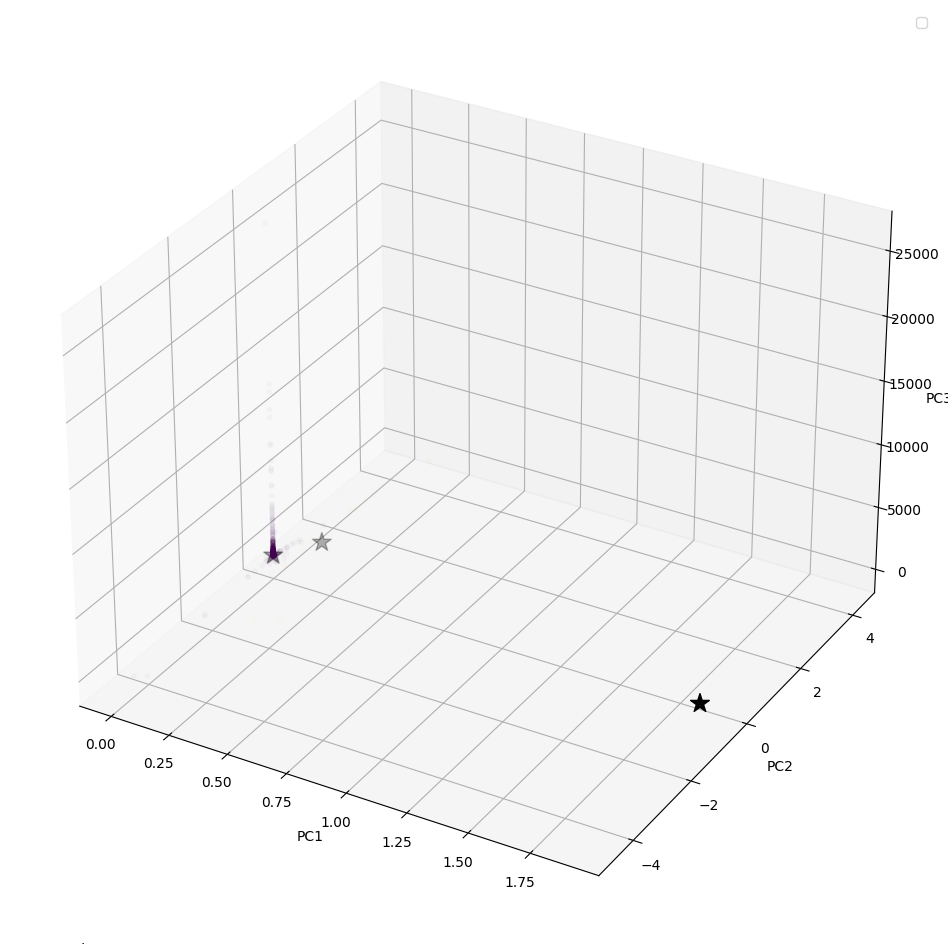

In [107]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(CONSUMER_ID.PC1,
           CONSUMER_ID.PC2,
           CONSUMER_ID.PC3,
           alpha = 0.02, s = 10,
           # cmap = ["#F58220", "#0086B8", "#043B72"])
           c = CONSUMER_ID["Kmeans_cluster"])

ax.scatter(
    Centroid[:, 0],
    Centroid[:, 1],
    Centroid[:, 2],
    c = "black",
    s = 200,
    marker = "*"
)
  # [각 군집의 센터(평균값) 검은색 별표, 사이즈 200으로 설정]

ax.legend()
plt.show()

In [ ]:
class myDBSCAN():

    def __init__(self, eps = 5, min_samples = 5):
        self.eps = eps
        self.min_samples = min_samples
        self.is_core = None
        self.labels = None
        self.X = None

    def get_neighbor(self, point, data, eps):
        # eps 반경에 들어오는 데이터 여부
        return np.linalg.norm(data-point, axis=1) < eps

    def get_closest(self, target_idx, others_idx, X, eps):
        # 자신을 제외한 가장 가까운 데이터 인덱스 반환
        point = X[target_idx]
        data = X[others_idx]
        return others_idx[np.argmin(np.linalg.norm(data-point, axis=1))]

    def fit(self, X):

        def assign_cluster(core_idx, X, is_core, eps):
            if core_idx in visited_idx:
                return
            visited_idx.append(core_idx)
            neighbor_idx = np.where(self.get_neighbor(X[core_idx], X, eps) == True)[0]
            neighbor_idx = set(neighbor_idx)-set(non_core_idx)

            if len(neighbor_idx) == 0:
                return

            for ni in neighbor_idx:
                if labels[ni] == -1:
                    labels[ni] = cluster_label
            other_idx = np.array(list(set(neighbor_idx)-set(visited_idx)))

            for ci in other_idx:
                assign_cluster(ci, X, is_core, eps)

        # Assign core and non-core
        is_core = []
        for i in range(X.shape[0]):
            target_data = X[i]
            if np.sum(self.get_neighbor(target_data, X, eps)) >= min_samples:
                is_core.append(1)
            else:
                is_core.append(-1)

        is_core = np.array(is_core)
        self.is_core = is_core

        # Assign Cluster
        labels = np.array([-1]*X.shape[0])
        core_indice = np.where(is_core == 1)[0]
        init_core_idx = core_indice[0]
          # initial core point
        cluster_label = 0
        labels = np.array([-1]*X.shape[0])
        non_core_idx = np.where(is_core == -1)[0]
        visited_idx = []
          # 클러스터 할당된 core point
        prev_cluster_list = []
          # 이전 클래스 라벨 리스트

        while True:
            assign_cluster(init_core_idx, X, is_core, eps) ## Assign core point cluster
            temp_labels = labels.copy()
            temp_not_assign_cluster_idx = np.where(labels == -1)[0]
            assign_cluster_idx = [i for i, x in enumerate(labels) if x != -1 and x in prev_cluster_list]

            # Assign non core point cluster
            for nci in non_core_idx:
                others_idx = np.array(list(set(range(X.shape[0]))-set([nci])))
                neighbor_idx = np.where(self.get_neighbor(X[nci], X, eps) == True)[0]
                if len(neighbor_idx) == 0:
                    continue

                others_idx = set(neighbor_idx) - set(temp_not_assign_cluster_idx)-set([nci])-set(assign_cluster_idx)
                if len(others_idx) == 0:
                    continue
                others_idx = np.array(list(others_idx))
                closest_neighbor_idx = self.get_closest(nci, others_idx, X, eps)
                labels[nci] = labels[closest_neighbor_idx]

            not_assign_cluster_idx = np.where(labels == -1)[0]

            if len(set(core_indice).intersection(not_assign_cluster_idx)) == 0:
                break

            core_indice = np.array(list(set(core_indice).intersection(not_assign_cluster_idx)))
            non_core_idx = np.array(list(set(non_core_idx).intersection(not_assign_cluster_idx)))
            init_core_idx = core_indice[0]
              # initial core point

            prev_cluster_list.append(cluster_label)
            cluster_label += 1
            visited_idx = np.where(labels != -1)[0].tolist()

        self.labels = labels

        return self


# line 1~7
# myDBSCAN 클래스는 반경과 최소 샘플 수를 받게 했다.

# line 9~17
# 특정 포인트를 중심으로 반경 내에 데이터가 들어오는지 여부를 반환하는 get_neighbor, 특정 데이터를 중심으로 가장 가까운 다른 데이터의 인덱스를 반환하는 get_closest 메서드를 정의했다.

# line 19~83
# 제일 중요한 fit 메서드이다. 우선 핵심 데이터에 클러스터를 할당하는 함수 assign_cluster를 내부에 정의했다(line 20~33). assign_cluster는 재귀적으로 핵심 데이터에 클러스터를 할당하며 반경 내 클러스터를 할당받지 못한 데이터 또는 반경 내 데이터가 없다면 종료한다.

# 다음으로 모든 데이터를 핵심 데이터와 비 핵심 데이터로 나눈다(line 35~44). 다음으로 클러스터를 할당한다. 이때 핵심 데이터에 대해서 클러스터를 할당한 뒤(line 56), 비 핵심 데이터를 클러스터로 할당한다(line 61~72). 이제 클러스터를 할당받지 못한 핵심 데이터가 없다면 종료하고 아니면 클러스터 할당 과정을 반복하게 된다.

# 예제
# 구현을 했으니 테스트를 해볼 시간이다. 여기에서는 내가 구현한 것과 Scikit-Learn에서 제공하는 DBSCAN 클래스를 사용하여 클러스터링 한 후 그 결과를 비교해보고자 한다.

# 데이터는 아래의 지출 점수 관련 데이터를 사용했으며 아래에 첨부해 두었다.
# 여기서는 지출 점수(Spending_Score)와 연 수입(Annual_Income)만 고려했다.


```
font_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/NanumSquareRoundR.ttf"
font_name = fm.FontProperties(fname = font_path, size = 10).get_name()
plt.rc("font", family = font_name)
  # plt.rcParams["font.family"] = font_name

correlation = CS_DATA_M2_3_Scaled.drop("고객번호", axis = 1).corr()
mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from( mask )] = True

sns.heatmap(
    data = correlation,
    cmap = "GnBu_r",
    annot = True,
    fmt = "0.01f",
    mask = mask,
      # [표시하지 않을 위쪽 삼각형 마스크 부분 지정]
    linewidths = 0.5,
      # [경계면 실선으로 구분]
    vmin = -1,
    vmax = 1
      # [colorbar의 범위 -1 ~ 1로 지정]
)
plt.show()
```